# NASDAQ 100 Data Integration and Forecasting

**Installing Necessary Libraries**

In [36]:
!pip install yfinance

**Downloading and Merging NASDAQ-100 Stock Data**

In [37]:
import yfinance as yf
import pandas as pd
from functools import reduce
from datetime import datetime

tickers = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOG', 'GOOGL', 'AVGO', 'COST', 'PEP',
    'ADBE', 'TSLA', 'AMD', 'CMCSA', 'NFLX', 'INTC', 'CSCO', 'AMGN', 'TMUS', 'QCOM',
    'TXN', 'HON', 'INTU', 'SBUX', 'ISRG', 'AMAT', 'BKNG', 'ADI', 'MDLZ', 'REGN',
    'VRTX', 'GILD', 'MU', 'ADP', 'PANW', 'LRCX', 'MAR', 'KLAC', 'CTSH', 'CDNS',
    'CSGP', 'ORLY', 'DXCM', 'ROST', 'MNST', 'KDP', 'FTNT', 'IDXX', 'AZN', 'BIIB',
    'WDAY', 'CHTR', 'PAYX', 'ODFL', 'ANSS', 'AEP', 'EA', 'XEL', 'DLTR', 'MELI',
    'PCAR', 'ALGN', 'FAST', 'CPRT', 'CTAS', 'CDW', 'WBD', 'VRSK', 'BKR', 'SIRI',
    'EBAY', 'WBA', 'MTCH', 'BIDU', 'JD', 'TTWO', 'VRSN', 'ULTA', 'NXPI', 'CHKP', 'INCY'
]

start_date = "2015-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Base date range
base_dates = pd.date_range(start=start_date, end=end_date, freq='B')
base_df = pd.DataFrame({'Date': base_dates})

stock_dfs = []
failed_tickers = []

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date, auto_adjust=False)

        if hist.empty or 'Close' not in hist.columns or 'Volume' not in hist.columns:
            raise ValueError("Missing 'Close' or 'Volume'")

        # Normalize timezone to prevent merge conflict
        df = pd.DataFrame({
            'Date': hist.index.tz_localize(None),  # Strip timezone
            f"{ticker}_CLOSE": hist['Close'].values,
            f"{ticker}_VOLUME": hist['Volume'].values
        })

        df = pd.merge(base_df, df, on='Date', how='left')
        stock_dfs.append(df)

    except Exception as e:
        print(f"Error downloading {ticker}: {e}")
        failed_tickers.append(ticker)

# Final merge
if not stock_dfs:
    raise RuntimeError("All downloads failed. No data to merge.")

final_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), stock_dfs)
final_df.sort_values("Date", inplace=True)
final_df.to_csv(r"D:\Masters Study Abroad\BA 2nd Sem\IS6611 Applied Research in Business Analytics\IS6611 IT Artefact V3\Final Files\Final Datasets\NASDAQ Datasets\NASDAQ_100_final_timezone_fixed.csv", index=False)

print("\nMerge complete.")
print(f"Tickers downloaded: {len(stock_dfs)}")
print(f"Failed tickers: {failed_tickers if failed_tickers else 'None'}")
final_df.head()



Merge complete.
Tickers downloaded: 81
Failed tickers: None


,Date,AAPL_CLOSE,AAPL_VOLUME,MSFT_CLOSE,MSFT_VOLUME,AMZN_CLOSE,AMZN_VOLUME,NVDA_CLOSE,NVDA_VOLUME,META_CLOSE,...,VRSN_CLOSE,VRSN_VOLUME,ULTA_CLOSE,ULTA_VOLUME,NXPI_CLOSE,NXPI_VOLUME,CHKP_CLOSE,CHKP_VOLUME,INCY_CLOSE,INCY_VOLUME
0,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,27.332500,212818400.0,46.759998,27913900.0,15.4260,55664000.0,0.50325,113680000.0,78.449997,...,57.189999,684500.0,126.839996,410800.0,76.809998,2566600.0,78.459999,569000.0,73.760002,775100.0
2,2015-01-05,26.562500,257142000.0,46.330002,39673900.0,15.1095,55484000.0,0.49475,197952000.0,77.190002,...,56.240002,874400.0,127.150002,477400.0,76.000000,3929600.0,78.010002,720800.0,74.220001,968900.0
3,2015-01-06,26.565001,263188400.0,45.650002,36447900.0,14.7645,70380000.0,0.47975,197764000.0,76.150002,...,55.180000,1289300.0,126.949997,758200.0,72.379997,4099700.0,77.949997,1641600.0,71.489998,2249200.0
4,2015-01-07,26.937500,160423600.0,46.230000,29114100.0,14.9210,52806000.0,0.47850,321808000.0,76.150002,...,55.639999,552400.0,130.580002,597200.0,74.330002,2713000.0,78.589996,751700.0,74.449997,1009100.0


**Calculating Top 5 and Bottom 5 Performing NASDAQ Stocks**

In [38]:
import numpy as np
import pandas as pd

# Assuming your merged file is loaded as:
df = pd.read_csv(r"D:\Masters Study Abroad\BA 2nd Sem\IS6611 Applied Research in Business Analytics\IS6611 IT Artefact V3\Final Files\Final Datasets\NASDAQ Datasets\NASDAQ_100_final_timezone_fixed.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Get all _CLOSE columns
close_cols = [col for col in df.columns if col.endswith('_CLOSE')]

cagr_results = []

for col in close_cols:
    stock_series = df[col].dropna()
    
    # Skip if not enough data
    if stock_series.shape[0] < 2:
        continue

    start_price = stock_series.iloc[0]
    end_price = stock_series.iloc[-1]
    start_date = stock_series.index[0]
    end_date = stock_series.index[-1]

    # Calculate the number of years between start and end
    years = (end_date - start_date).days / 365.25

    if start_price > 0 and years > 0:
        cagr = (end_price / start_price) ** (1 / years) - 1
        cagr_results.append({
            'Stock': col.replace('_CLOSE', ''),
            'CAGR': cagr,
            'Start Date': start_date.date(),
            'End Date': end_date.date()
        })

# Create DataFrame
cagr_df = pd.DataFrame(cagr_results)
cagr_df['CAGR (%)'] = cagr_df['CAGR'] * 100

# Sort by CAGR
cagr_df_sorted = cagr_df.sort_values(by='CAGR', ascending=False)

# Top and Bottom 5
top_5 = cagr_df_sorted.head(5).reset_index(drop=True)
bottom_5 = cagr_df_sorted.tail(5).reset_index(drop=True)

# Display Results
print("Top 5 Performing Stocks by CAGR (%):\n")
print(top_5[['Stock', 'CAGR (%)', 'Start Date', 'End Date']])

print("\nBottom 5 Performing Stocks by CAGR (%):\n")
print(bottom_5[['Stock', 'CAGR (%)', 'Start Date', 'End Date']])


Top 5 Performing Stocks by CAGR (%):

  Stock   CAGR (%)  Start Date    End Date
0  NVDA  73.043195  2015-01-02  2025-07-03
1   AMD  45.598273  2015-01-02  2025-07-03
2  AVGO  37.111419  2015-01-02  2025-07-03
3  NFLX  36.395298  2015-01-02  2025-07-03
4  TSLA  33.978513  2015-01-02  2025-07-03

Bottom 5 Performing Stocks by CAGR (%):

  Stock   CAGR (%)  Start Date    End Date
0   KDP  -6.902186  2015-01-02  2025-07-03
1  BIIB  -8.611230  2015-01-02  2025-07-03
2  BIDU  -8.643019  2015-01-02  2025-07-03
3   WBD -10.140741  2015-01-02  2025-07-03
4   WBA -16.481411  2015-01-02  2025-07-03


**VAR Forecasting for Top 5 Stocks**

**NVDA**

C:\Users\shamg\AppData\Local\Temp\ipykernel_1532\501901937.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_stock = ts_stock.asfreq('B').fillna(method='ffill')


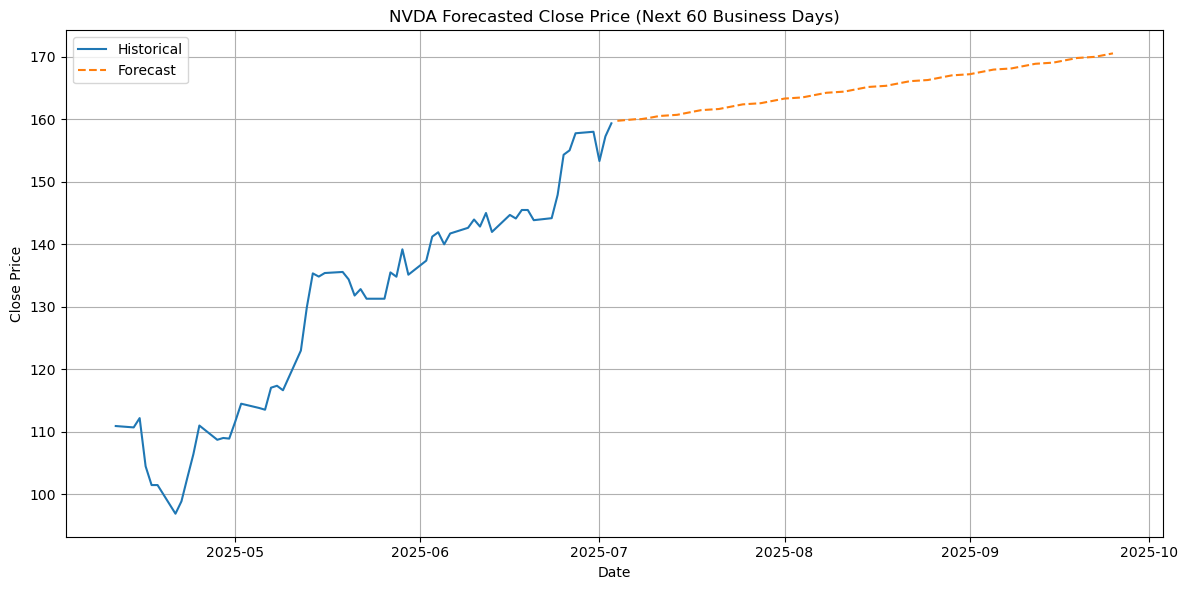


VAR Model Summary for NVDA (Lag=4):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Jul, 2025
Time:                     12:49:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    39.4136
Nobs:                     778.000    HQIC:                   39.3473
Log likelihood:          -17479.8    FPE:                1.17574e+17
AIC:                      39.3058    Det(Omega_mle):     1.14901e+17
--------------------------------------------------------------------
Results for equation NVDA_CLOSE
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.203592         0.102127            1.994           0.046
L1.NVDA_CLOSE         -0.081892         0.036200           -2.262           0.024
L1.NVDA_VOLUME

In [39]:
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt
import pandas as pd

# 1. Define the stock
stock = 'NVDA'

# 2. Prepare the data
ts_stock = df[[f'{stock}_CLOSE', f'{stock}_VOLUME']].dropna()

# 3. Use only last 3 years (or change to 5 if needed)
end_date = ts_stock.index.max()
start_cutoff = end_date - pd.DateOffset(years=3)
ts_stock = ts_stock.loc[ts_stock.index >= start_cutoff]

# 4. Set business day frequency and forward fill missing
ts_stock = ts_stock.asfreq('B').fillna(method='ffill')

# 5. Difference the series to make it stationary
ts_stock_diff = ts_stock.diff().dropna()

# 6. Fit the VAR model
model = VAR(ts_stock_diff)
lag_order = model.select_order(15).aic
fitted_model = model.fit(lag_order)

# 7. Forecast next 60 business days
forecast_steps = 60
forecast_input = ts_stock_diff.values[-lag_order:]
forecast = fitted_model.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=ts_stock_diff.columns)

# 8. Invert differencing
last_known = ts_stock.iloc[-1]
forecast_cumsum = forecast_df.cumsum()
forecast_restored = forecast_cumsum.add(last_known)

# 9. Assign dates to forecast
forecast_dates = pd.date_range(start=ts_stock.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_restored.index = forecast_dates

# 10. Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_stock[f'{stock}_CLOSE'][-60:], label='Historical')
plt.plot(forecast_restored[f'{stock}_CLOSE'], label='Forecast', linestyle='--')
plt.title(f"{stock} Forecasted Close Price (Next {forecast_steps} Business Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Print summary
print(f"\nVAR Model Summary for {stock} (Lag={lag_order}):")
print(fitted_model.summary())

# 12. Ljung-Box Test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box Test for Residuals (one per variable):")
for col in fitted_model.resid.columns:
    lb_test = acorr_ljungbox(fitted_model.resid[col], lags=[lag_order], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]
    print(f"{col}: p-value = {p_value:.4f} {'No autocorrelation' if p_value > 0.05 else 'Possibly autocorrelated'}")

In [40]:
forecasted_closes = {}
forecasted_closes['NVDA'] = forecast_restored

**AMD**

C:\Users\shamg\AppData\Local\Temp\ipykernel_1532\1466095722.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_stock = ts_stock.asfreq('B').fillna(method='ffill')


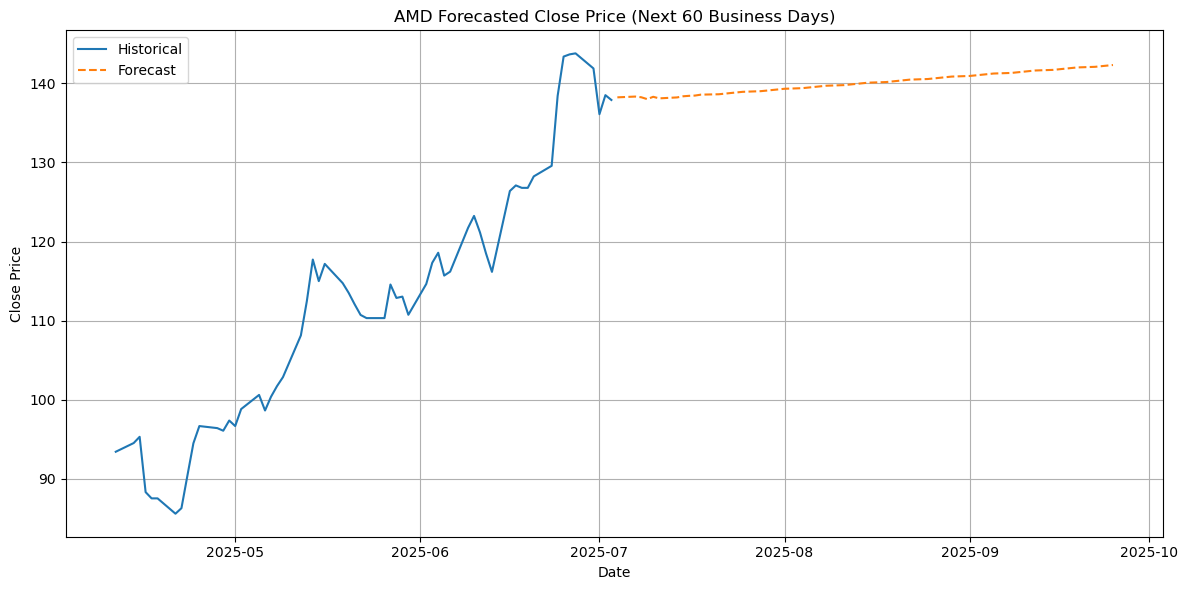


VAR Model Summary for AMD (Lag=6):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Jul, 2025
Time:                     12:49:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    36.0652
Nobs:                     776.000    HQIC:                   35.9693
Log likelihood:          -16109.0    FPE:                3.93741e+15
AIC:                      35.9093    Det(Omega_mle):     3.80873e+15
--------------------------------------------------------------------
Results for equation AMD_CLOSE
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.073227         0.133213            0.550           0.583
L1.AMD_CLOSE         -0.002134         0.036165           -0.059           0.953
L1.AMD_VOLUME       

In [41]:
# 1. Define the stock
stock = 'AMD'

# 2. Prepare the data
ts_stock = df[[f'{stock}_CLOSE', f'{stock}_VOLUME']].dropna()

# 3. Use only last 3 years (or change to 5 if needed)
end_date = ts_stock.index.max()
start_cutoff = end_date - pd.DateOffset(years=3)
ts_stock = ts_stock.loc[ts_stock.index >= start_cutoff]

# 4. Set business day frequency and forward fill missing
ts_stock = ts_stock.asfreq('B').fillna(method='ffill')

# 5. Difference the series to make it stationary
ts_stock_diff = ts_stock.diff().dropna()

# 6. Fit the VAR model
model = VAR(ts_stock_diff)
lag_order = model.select_order(15).aic
fitted_model = model.fit(lag_order)

# 7. Forecast next 60 business days
forecast_steps = 60
forecast_input = ts_stock_diff.values[-lag_order:]
forecast = fitted_model.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=ts_stock_diff.columns)

# 8. Invert differencing
last_known = ts_stock.iloc[-1]
forecast_cumsum = forecast_df.cumsum()
forecast_restored = forecast_cumsum.add(last_known)

# 9. Assign dates to forecast
forecast_dates = pd.date_range(start=ts_stock.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_restored.index = forecast_dates

# 10. Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_stock[f'{stock}_CLOSE'][-60:], label='Historical')
plt.plot(forecast_restored[f'{stock}_CLOSE'], label='Forecast', linestyle='--')
plt.title(f"{stock} Forecasted Close Price (Next {forecast_steps} Business Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Print summary
print(f"\nVAR Model Summary for {stock} (Lag={lag_order}):")
print(fitted_model.summary())

# 12. Ljung-Box Test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box Test for Residuals (one per variable):")
for col in fitted_model.resid.columns:
    lb_test = acorr_ljungbox(fitted_model.resid[col], lags=[lag_order], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]
    print(f"{col}: p-value = {p_value:.4f} {'No autocorrelation' if p_value > 0.05 else 'Possibly autocorrelated'}")

In [42]:
forecasted_closes['AMD'] = forecast_restored

**AVGO**

C:\Users\shamg\AppData\Local\Temp\ipykernel_1532\3233196051.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_stock = ts_stock.asfreq('B').fillna(method='ffill')


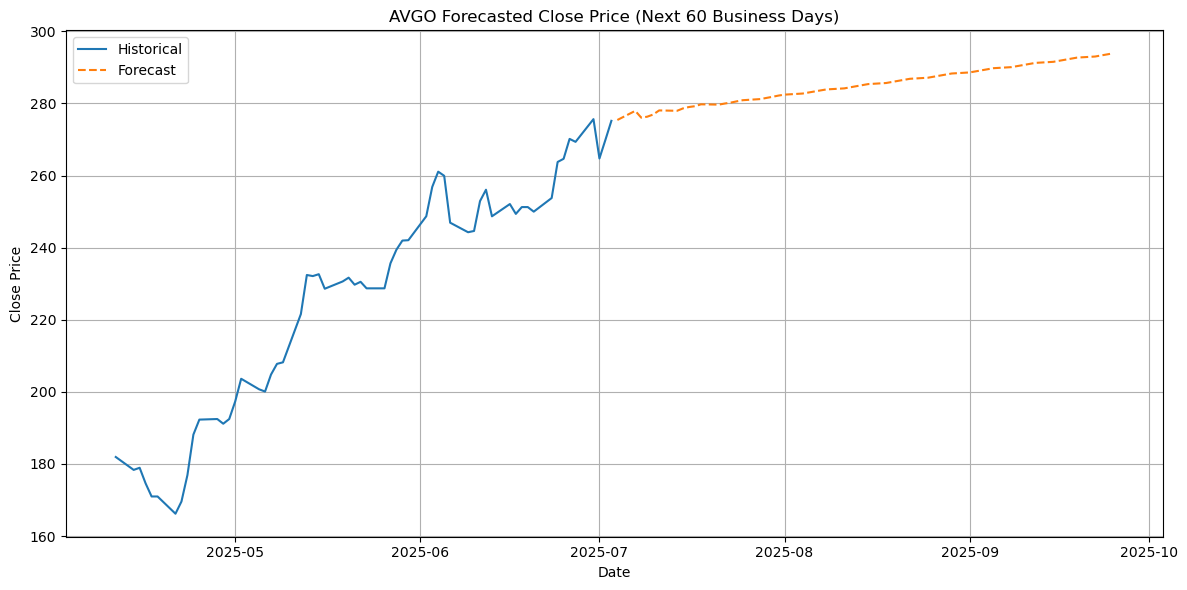


VAR Model Summary for AVGO (Lag=9):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Jul, 2025
Time:                     12:49:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    36.0045
Nobs:                     773.000    HQIC:                   35.8639
Log likelihood:          -15983.1    FPE:                3.44575e+15
AIC:                      35.7759    Det(Omega_mle):     3.28241e+15
--------------------------------------------------------------------
Results for equation AVGO_CLOSE
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.303602         0.164081            1.850           0.064
L1.AVGO_CLOSE         -0.001972         0.036424           -0.054           0.957
L1.AVGO_VOLUME

In [43]:
# 1. Define the stock
stock = 'AVGO'

# 2. Prepare the data
ts_stock = df[[f'{stock}_CLOSE', f'{stock}_VOLUME']].dropna()

# 3. Use only last 3 years (or change to 5 if needed)
end_date = ts_stock.index.max()
start_cutoff = end_date - pd.DateOffset(years=3)
ts_stock = ts_stock.loc[ts_stock.index >= start_cutoff]

# 4. Set business day frequency and forward fill missing
ts_stock = ts_stock.asfreq('B').fillna(method='ffill')

# 5. Difference the series to make it stationary
ts_stock_diff = ts_stock.diff().dropna()

# 6. Fit the VAR model
model = VAR(ts_stock_diff)
lag_order = model.select_order(15).aic
fitted_model = model.fit(lag_order)

# 7. Forecast next 60 business days
forecast_steps = 60
forecast_input = ts_stock_diff.values[-lag_order:]
forecast = fitted_model.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=ts_stock_diff.columns)

# 8. Invert differencing
last_known = ts_stock.iloc[-1]
forecast_cumsum = forecast_df.cumsum()
forecast_restored = forecast_cumsum.add(last_known)

# 9. Assign dates to forecast
forecast_dates = pd.date_range(start=ts_stock.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_restored.index = forecast_dates

# 10. Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_stock[f'{stock}_CLOSE'][-60:], label='Historical')
plt.plot(forecast_restored[f'{stock}_CLOSE'], label='Forecast', linestyle='--')
plt.title(f"{stock} Forecasted Close Price (Next {forecast_steps} Business Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Print summary
print(f"\nVAR Model Summary for {stock} (Lag={lag_order}):")
print(fitted_model.summary())

# 12. Ljung-Box Test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box Test for Residuals (one per variable):")
for col in fitted_model.resid.columns:
    lb_test = acorr_ljungbox(fitted_model.resid[col], lags=[lag_order], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]
    print(f"{col}: p-value = {p_value:.4f} {'No autocorrelation' if p_value > 0.05 else 'Possibly autocorrelated'}")

In [44]:
forecasted_closes['AVGO'] = forecast_restored

**NFLX**

C:\Users\shamg\AppData\Local\Temp\ipykernel_1532\3738200960.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_stock = ts_stock.asfreq('B').fillna(method='ffill')


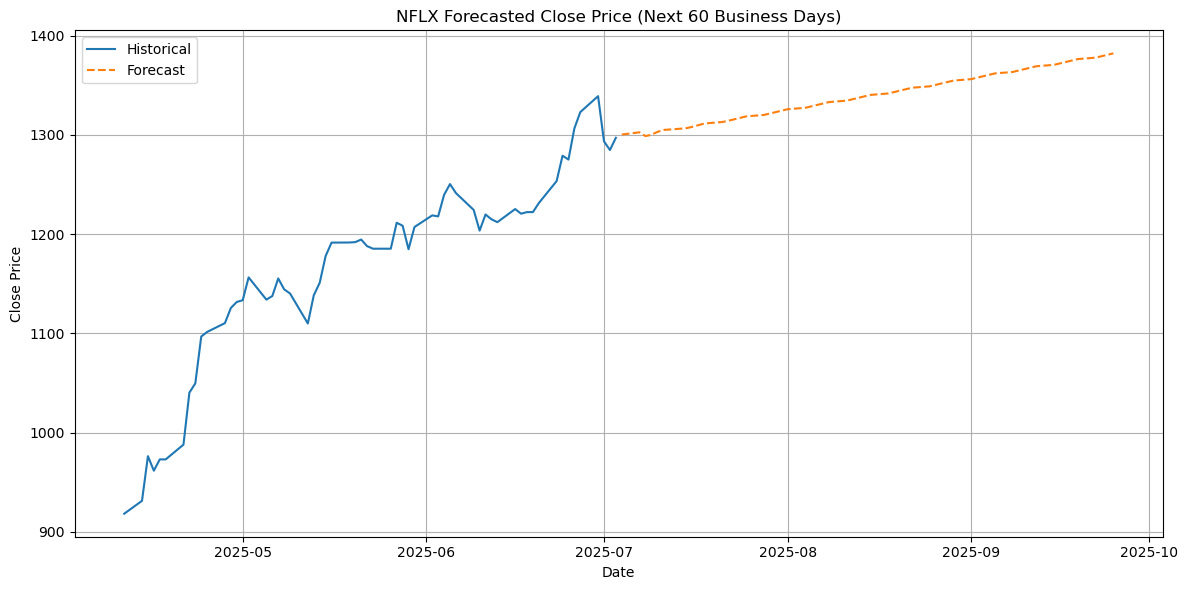


VAR Model Summary for NFLX (Lag=5):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Jul, 2025
Time:                     12:49:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    35.2445
Nobs:                     777.000    HQIC:                   35.1634
Log likelihood:          -15824.3    FPE:                1.77519e+15
AIC:                      35.1127    Det(Omega_mle):     1.72597e+15
--------------------------------------------------------------------
Results for equation NFLX_CLOSE
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  1.307627         0.476956            2.742           0.006
L1.NFLX_CLOSE         -0.005164         0.036419           -0.142           0.887
L1.NFLX_VOLUME

In [45]:
# 1. Define the stock
stock = 'NFLX'

# 2. Prepare the data
ts_stock = df[[f'{stock}_CLOSE', f'{stock}_VOLUME']].dropna()

# 3. Use only last 3 years (or change to 5 if needed)
end_date = ts_stock.index.max()
start_cutoff = end_date - pd.DateOffset(years=3)
ts_stock = ts_stock.loc[ts_stock.index >= start_cutoff]

# 4. Set business day frequency and forward fill missing
ts_stock = ts_stock.asfreq('B').fillna(method='ffill')

# 5. Difference the series to make it stationary
ts_stock_diff = ts_stock.diff().dropna()

# 6. Fit the VAR model
model = VAR(ts_stock_diff)
lag_order = model.select_order(15).aic
fitted_model = model.fit(lag_order)

# 7. Forecast next 60 business days
forecast_steps = 60
forecast_input = ts_stock_diff.values[-lag_order:]
forecast = fitted_model.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=ts_stock_diff.columns)

# 8. Invert differencing
last_known = ts_stock.iloc[-1]
forecast_cumsum = forecast_df.cumsum()
forecast_restored = forecast_cumsum.add(last_known)

# 9. Assign dates to forecast
forecast_dates = pd.date_range(start=ts_stock.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_restored.index = forecast_dates

# 10. Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_stock[f'{stock}_CLOSE'][-60:], label='Historical')
plt.plot(forecast_restored[f'{stock}_CLOSE'], label='Forecast', linestyle='--')
plt.title(f"{stock} Forecasted Close Price (Next {forecast_steps} Business Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Print summary
print(f"\nVAR Model Summary for {stock} (Lag={lag_order}):")
print(fitted_model.summary())

# 12. Ljung-Box Test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box Test for Residuals (one per variable):")
for col in fitted_model.resid.columns:
    lb_test = acorr_ljungbox(fitted_model.resid[col], lags=[lag_order], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]
    print(f"{col}: p-value = {p_value:.4f} {'No autocorrelation' if p_value > 0.05 else 'Possibly autocorrelated'}")

In [46]:
forecasted_closes['NFLX'] = forecast_restored

**TSLA**

C:\Users\shamg\AppData\Local\Temp\ipykernel_1532\1844249523.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_stock = ts_stock.asfreq('B').fillna(method='ffill')


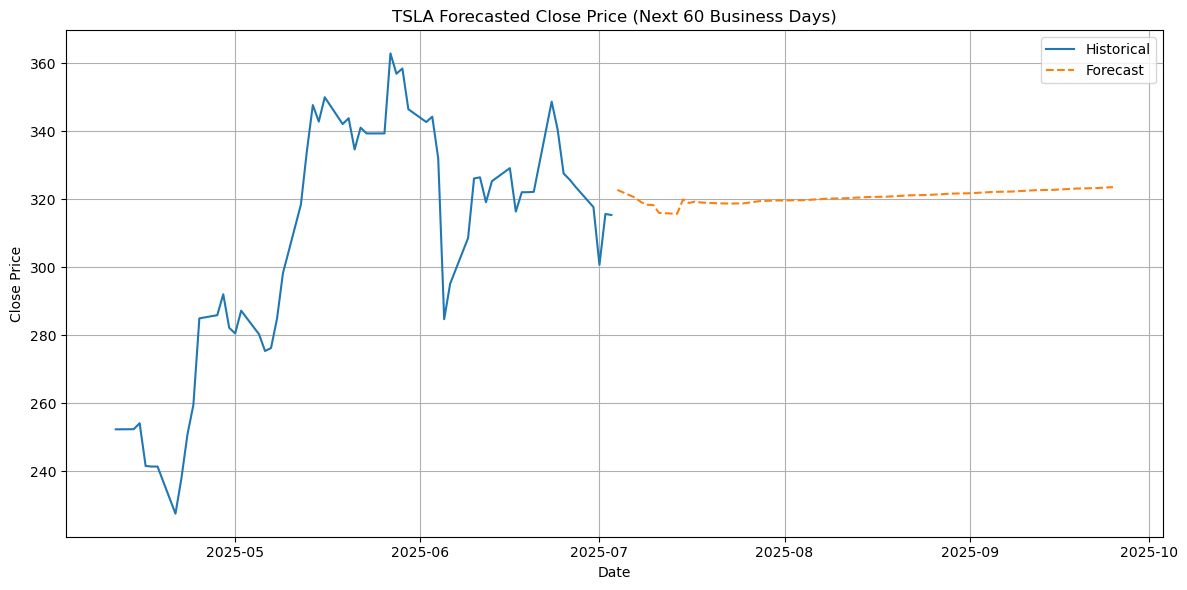


VAR Model Summary for TSLA (Lag=9):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Jul, 2025
Time:                     12:49:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    38.8566
Nobs:                     773.000    HQIC:                   38.7160
Log likelihood:          -17085.4    FPE:                5.96971e+16
AIC:                      38.6280    Det(Omega_mle):     5.68672e+16
--------------------------------------------------------------------
Results for equation TSLA_CLOSE
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.080867         0.341347            0.237           0.813
L1.TSLA_CLOSE          0.006762         0.036232            0.187           0.852
L1.TSLA_VOLUME

In [47]:
# 1. Define the stock
stock = 'TSLA'

# 2. Prepare the data
ts_stock = df[[f'{stock}_CLOSE', f'{stock}_VOLUME']].dropna()

# 3. Use only last 3 years (or change to 5 if needed)
end_date = ts_stock.index.max()
start_cutoff = end_date - pd.DateOffset(years=3)
ts_stock = ts_stock.loc[ts_stock.index >= start_cutoff]

# 4. Set business day frequency and forward fill missing
ts_stock = ts_stock.asfreq('B').fillna(method='ffill')

# 5. Difference the series to make it stationary
ts_stock_diff = ts_stock.diff().dropna()

# 6. Fit the VAR model
model = VAR(ts_stock_diff)
lag_order = model.select_order(15).aic
fitted_model = model.fit(lag_order)

# 7. Forecast next 60 business days
forecast_steps = 60
forecast_input = ts_stock_diff.values[-lag_order:]
forecast = fitted_model.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=ts_stock_diff.columns)

# 8. Invert differencing
last_known = ts_stock.iloc[-1]
forecast_cumsum = forecast_df.cumsum()
forecast_restored = forecast_cumsum.add(last_known)

# 9. Assign dates to forecast
forecast_dates = pd.date_range(start=ts_stock.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_restored.index = forecast_dates

# 10. Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_stock[f'{stock}_CLOSE'][-60:], label='Historical')
plt.plot(forecast_restored[f'{stock}_CLOSE'], label='Forecast', linestyle='--')
plt.title(f"{stock} Forecasted Close Price (Next {forecast_steps} Business Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Print summary
print(f"\nVAR Model Summary for {stock} (Lag={lag_order}):")
print(fitted_model.summary())

# 12. Ljung-Box Test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box Test for Residuals (one per variable):")
for col in fitted_model.resid.columns:
    lb_test = acorr_ljungbox(fitted_model.resid[col], lags=[lag_order], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]
    print(f"{col}: p-value = {p_value:.4f} {'No autocorrelation' if p_value > 0.05 else 'Possibly autocorrelated'}")

In [48]:
forecasted_closes['TSLA'] = forecast_restored

**Saving the forecasted dataset**

In [49]:
# 1. Define top 5 stocks
top_5_stocks = ['NVDA', 'AMD', 'AVGO', 'NFLX', 'TSLA']

# 2. Extract actuals
actuals = df[[f"{stock}_CLOSE" for stock in top_5_stocks]].copy()
actuals.reset_index(inplace=True)  # 'Date' was index
actuals['Type'] = 'Actual'

# 3. Collect forecasted values into one DataFrame
forecast_frames = []

for stock in top_5_stocks:
    try:
        forecast_df = forecasted_closes[stock].copy()  # must exist from your earlier steps
    except KeyError:
        print(f"⚠️ No forecast found for {stock}, skipping.")
        continue

    # Rename to match actuals (e.g., NVDA → NVDA_CLOSE)
    forecast_df = forecast_df[[f'{stock}_CLOSE']].copy()
    forecast_df.columns = [f'{stock}_CLOSE']
    forecast_df.reset_index(inplace=True)
    forecast_df.rename(columns={'index': 'Date'}, inplace=True)
    forecast_df['Type'] = 'Forecasted'
    forecast_frames.append(forecast_df)

# 4. Merge all forecast DataFrames on 'Date'
from functools import reduce

if forecast_frames:
    forecast_merged = reduce(lambda left, right: pd.merge(left, right, on=['Date', 'Type'], how='outer'), forecast_frames)
else:
    forecast_merged = pd.DataFrame()

# 5. Combine with actuals
final_df = pd.concat([actuals, forecast_merged], ignore_index=True, sort=False)
final_df.sort_values(by='Date', inplace=True)
final_df.reset_index(drop=True, inplace=True)


In [50]:
final_df.head()

,Date,NVDA_CLOSE,AMD_CLOSE,AVGO_CLOSE,NFLX_CLOSE,TSLA_CLOSE,Type
0,2015-01-01,NaN,NaN,NaN,NaN,NaN,Actual
1,2015-01-02,0.50325,2.67,10.009,49.848572,14.620667,Actual
2,2015-01-05,0.49475,2.66,9.849,47.311428,14.006000,Actual
3,2015-01-06,0.47975,2.63,9.625,46.501431,14.085333,Actual
4,2015-01-07,0.47850,2.58,9.885,46.742859,14.063333,Actual


In [51]:
final_df.tail()

,Date,NVDA_CLOSE,AMD_CLOSE,AVGO_CLOSE,NFLX_CLOSE,TSLA_CLOSE,Type
2797,2025-09-19,169.787847,142.027562,292.721967,1376.519167,323.142106,Forecasted
2798,2025-09-22,169.973264,142.104670,293.016058,1377.963239,323.242254,Forecasted
2799,2025-09-23,170.158680,142.181779,293.310069,1379.407312,323.342365,Forecasted
2800,2025-09-24,170.344097,142.258887,293.604028,1380.851384,323.442526,Forecasted
2801,2025-09-25,170.529513,142.335995,293.897978,1382.295457,323.542628,Forecasted


In [52]:
# 6. Save to CSV
final_df.to_csv(r"D:\Masters Study Abroad\BA 2nd Sem\IS6611 Applied Research in Business Analytics\IS6611 IT Artefact V3\Final Files\Final Datasets\NASDAQ Datasets\NASDAQ_100_top_performers.csv", index=False)

# Calculating the Portfolio Growth
**Simulating investments, invested equally in the top 5 stocks (NVDA, AMD, AVGO, NFLX, TSLA) back in 2015**

In [63]:
import pandas as pd

# Use actuals only (up to the last real date before forecast)
top_5_stocks = ['NVDA', 'AMD', 'AVGO', 'NFLX', 'TSLA']
close_cols = [f'{stock}_CLOSE' for stock in top_5_stocks]

# Extract close price data
actuals_df = df[close_cols].copy()
actuals_df = actuals_df.dropna(how='any')  # only use dates with all 5 present
actuals_df.reset_index(inplace=True)
actuals_df.rename(columns={'index': 'Date'}, inplace=True)

# Step 1: Normalize all stocks to start at 1.0
normalized_df = actuals_df.copy()
for col in close_cols:
    normalized_df[col] = normalized_df[col] / normalized_df[col].iloc[0]

# Step 2: Calculate equal-weighted portfolio value
normalized_df['Portfolio_Growth (%)'] = normalized_df[close_cols].mean(axis=1)

# Step 4: Keep only necessary columns
ideal_portfolio_growth_df = normalized_df[['Date', 'Portfolio_Growth (%)']]

In [64]:
ideal_portfolio_growth_df.head()

,Date,Portfolio_Growth (%)
0,2015-01-02,1.000000
1,2015-01-05,0.974088
2,2015-01-06,0.959239
3,2015-01-07,0.960860
4,2015-01-08,0.983992


In [65]:
ideal_portfolio_growth_df.tail()

,Date,Portfolio_Growth (%)
2636,2025-06-27,88.582517
2637,2025-06-30,88.643284
2638,2025-07-01,85.713150
2639,2025-07-02,87.735879
2640,2025-07-03,88.671617


In [67]:
#Save to CSV
ideal_portfolio_growth_df.to_csv(r"D:\Masters Study Abroad\BA 2nd Sem\IS6611 Applied Research in Business Analytics\IS6611 IT Artefact V3\Final Files\Final Datasets\NASDAQ Datasets\Top_performers_Portfolio_Growth.csv", index=False)